In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm, trange
import random

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, AutoModel, BitsAndBytesConfig
from peft import (
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
)
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Kaggle Data
df = pd.read_csv('./kaggle-llm-science-exam/train.csv')
df.head()

,id,prompt,A,B,C,D,E,answer
0,0,Which of the following statements accurately d...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...,D
1,1,Which of the following is an accurate definiti...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,A
2,2,Which of the following statements accurately d...,The triskeles symbol was reconstructed as a fe...,The triskeles symbol is a representation of th...,The triskeles symbol is a representation of a ...,The triskeles symbol represents three interloc...,The triskeles symbol is a representation of th...,A
3,3,What is the significance of regularization in ...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,C
4,4,Which of the following statements accurately d...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,D


In [ ]:
# Tumor Data

train_data = pd.read_csv('../data/siamese/train_data.csv')
test_data = pd.read_csv('../data/siamese/test_data.csv')

In [23]:
train_data['label'] = train_data['label'].apply(lambda x: 1 if x == 1 else -1)
test_data['label'] = test_data['label'].apply(lambda x: 1 if x == 1 else -1)

In [24]:
train_idx = random.sample(range(len(train_data)), 64)
test_idx = random.sample(range(len(test_data)), 64)

train_data = [train_data.iloc[i,:] for i in train_idx]
test_data = [test_data.iloc[i,:] for i in test_idx]

In [25]:
train_data = pd.DataFrame(train_data).reset_index(drop=True)
test_data = pd.DataFrame(test_data).reset_index(drop=True)


# Importing and formating data

In [3]:
df = pd.melt(df, id_vars=['prompt','answer'], value_vars=['A', 'B', 'C', 'D', 'E'], var_name='Column', value_name='answer_text')
df['labels'] = np.where(df['answer']==df['Column'],1,0)
df = df.drop(['answer','Column'], axis=1)
df = df.reset_index(drop = True)
df

,prompt,answer_text,labels
0,Which of the following statements accurately d...,MOND is a theory that reduces the observed mis...,0
1,Which of the following is an accurate definiti...,Dynamic scaling refers to the evolution of sel...,1
2,Which of the following statements accurately d...,The triskeles symbol was reconstructed as a fe...,1
3,What is the significance of regularization in ...,Regularizing the mass-energy of an electron wi...,0
4,Which of the following statements accurately d...,The angular spacing of features in the diffrac...,0
...,...,...,...
995,What is the relation between the three moment ...,The three moment theorem is used to derive the...,0
996,"What is the throttling process, and why is it ...",The throttling process is a steady adiabatic f...,0
997,What happens to excess base metal as a solutio...,"The excess base metal will often evaporate, be...",0
998,"What is the relationship between mass, force, ...",Mass is a property that determines the size of...,0


In [4]:
df['labels'].value_counts()

labels
0    800
1    200
Name: count, dtype: int64

# Loading bert large uncase model

In [ ]:
model_path = '../hf_model/models--bert-large-uncased/snapshots/6da4b6a26a1877e173fca3225479512db81a5e5b'

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModel.from_pretrained(model_path, output_hidden_states=True)

# Loading LLaMA3.1 model

In [ ]:
model_id = "../hf_model/models--meta-llama--Meta-Llama-3.1-8B-Instruct/snapshots/8c22764a7e3675c50d4c7c9a4edb474456022b16"
# saved_model_path = "../llama_finetuning/llama3.1_finetuning.pth"

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = "[PAD]"
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

config_kwargs = {
    "trust_remote_code": True,
    "cache_dir": None,
    "revision": 'main',
    "use_auth_token": None,
    "output_hidden_states": True
}
model_config = AutoConfig.from_pretrained(model_id, **config_kwargs)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(
    model_id,
    use_fast=False,
    trust_remote_code=True,
    padding_side="right",
    pad_token="[PAD]"
)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    config=model_config,
    torch_dtype=torch.float16,
    quantization_config=bnb_config,
    device_map='cuda:0')

model.config.pad_token_id = model.config.eos_token_id[0]
print(f"Pad token ID: {model.config.pad_token_id}, Type: {type(model.config.pad_token_id)}")
model.resize_token_embeddings(len(tokenizer)) 
model = prepare_model_for_kbit_training(model)

config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"], # https://github.com/huggingface/peft/blob/632997d1fb776c3cf05d8c2537ac9a98a7ce9435/src/peft/utils/other.py#L202
    lora_dropout=0.1,
    bias="none"
)
model = get_peft_model(model, config)
# model.load_state_dict(torch.load(saved_model_path))

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Pad token ID: 128001, Type: <class 'int'>


# Data prep for Siamese Network

In [12]:
class SiameseDataset(Dataset):
    def __init__(self, prompt, answer_text, labels):
        self.text1 = prompt
        self.text2 = answer_text
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text1 = self.text1[idx]
        text2 = self.text2[idx]
        label = self.labels[idx]
        return text1, text2, torch.tensor(label)

In [26]:
train_dataset = SiameseDataset(train_data["Report1"].tolist(),train_data["Report2"].tolist(), train_data["label"].tolist())
test_dataset = SiameseDataset(test_data["Report1"].tolist(),test_data["Report2"].tolist(), test_data["label"].tolist())

train_data_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [ ]:
# Kaggle Data
dataset = SiameseDataset(df["prompt"].tolist(),df["answer_text"].tolist(), df["labels"].tolist())
data_loader = DataLoader(dataset, batch_size=2, shuffle=True)

# Siamese Network Architecture

In [ ]:
# Base Model : BERT
class SiameseNetwork(nn.Module):
    def __init__(self, base_model):
        super(SiameseNetwork, self).__init__()
        self.base_model = base_model

    def forward(self, inputs1, inputs2):
        outputs1 = self.base_model(**inputs1).last_hidden_state[:, 0, :].squeeze()  
        outputs2 = self.base_model(**inputs2).last_hidden_state[:, 0, :].squeeze()
        return outputs1, outputs2

siamese_model = SiameseNetwork(model)

In [14]:
# Base Model : LLaMA3.1
# Layer : 1
class SiameseNetwork(nn.Module):
    def __init__(self, base_model):
        super(SiameseNetwork, self).__init__()
        self.base_model = base_model

    def forward(self, inputs1, inputs2):
        outputs1 = torch.mean(self.base_model(**inputs1).hidden_states[-1], axis=1)
        outputs2 = torch.mean(self.base_model(**inputs2).hidden_states[-1], axis=1)
        return outputs1, outputs2

siamese_model = SiameseNetwork(model)

In [ ]:
# Base Model : LLaMA3.1
# Layer : 5
class SiameseNetwork(nn.Module):
    def __init__(self, base_model):
        super(SiameseNetwork, self).__init__()
        self.base_model = base_model

    def forward(self, inputs1, inputs2):
        output1_5L = []
        output2_5L = []
        for layer in range(-1, -6, -1):
            output1_5L.append(torch.mean(self.base_model(**inputs1).hidden_states[layer], axis=1))
            output2_5L.append(torch.mean(self.base_model(**inputs2).hidden_states[layer], axis=1))
        output1_5L = torch.stack(output1_5L, axis=1).squeeze()
        output2_5L = torch.stack(output2_5L, axis=1).squeeze()
        return output1_5L, output2_5L
    
siamese_model = SiameseNetwork(model)

In [ ]:
text1 = train_dataset[0][0]
text2 = train_dataset[0][1]

inputs1 = tokenizer(text1, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
inputs2 = tokenizer(text2, padding="max_length", truncation=True, max_length=128, return_tensors="pt")

outputs1, outputs2 = siamese_model(inputs1, inputs2)

display(outputs1, outputs2)

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


tensor([[0.8991, 0.3776, 0.3680,  ..., 1.7692, 0.1399, 1.7671]],
       grad_fn=<MeanBackward1>)

tensor([[-0.1942, -0.4983,  1.6858,  ...,  1.7883,  0.3264,  1.6927]],
       grad_fn=<MeanBackward1>)

# Contrastive Loss for Siamese Network

In [ ]:
# Euclidean_Distance

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, outputs1, outputs2, labels):
        euclidean_distance = nn.functional.pairwise_distance(outputs1, outputs2, keepdim=True)
        loss_contrastive = torch.mean((1 - labels) * torch.pow(euclidean_distance, 2) +
                                      (labels) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [31]:
# Cosine_Similarity

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, outputs1, outputs2, labels):
        cosine_similarity = F.cosine_similarity(outputs1, outputs2)
        loss_contrastive = torch.mean((1 - labels) * torch.clamp(cosine_similarity - self.margin, min=0.0) +
                                (labels) * (1 - cosine_similarity))
        return loss_contrastive

# Training Loop

In [34]:
### LLaMA3.1 Tumor Data Training ###

model.config.use_cache = False
epochs = 5
best_val_loss = float('inf')

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
loss_fn = ContrastiveLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for epoch in trange(epochs):
    model.train()
    train_loss = 0
    for batch, sample in enumerate(tqdm(train_data_loader)):
        text1 = sample[0]
        text2 = sample[1]
        labels = sample[2]
        
        inputs1 = tokenizer(text1, padding="max_length", truncation=True, max_length=128, return_tensors="pt").to(device)
        inputs2 = tokenizer(text2, padding="max_length", truncation=True, max_length=128, return_tensors="pt").to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs1, outputs2 = siamese_model(inputs1, inputs2)
        loss = loss_fn(outputs1, outputs2, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        # torch.cuda.empty_cache()
    
    # scheduler.step()
    train_loss /= len(train_data_loader)
    print(f"Epoch {epoch+1}/{epochs} - Training Loss: {train_loss:.4f}")
    
    
    # Validation
    model.eval()
    model.config.use_cache = True
    val_loss = 0
    
    with torch.no_grad():
        for batch, sample in enumerate(tqdm(test_data_loader)):
            text1 = sample[0]
            text2 = sample[1]
            labels = sample[2]

            inputs1 = tokenizer(text1, padding="max_length", truncation=True, max_length=128, return_tensors="pt").to(device)
            inputs2 = tokenizer(text2, padding="max_length", truncation=True, max_length=128, return_tensors="pt").to(device)
            labels = labels.to(device)

            outputs1, outputs2 = siamese_model(inputs1, inputs2)
            loss = loss_fn(outputs1, outputs2, labels)
            val_loss += loss.item()
            
            # torch.cuda.empty_cache()
        
        val_loss /= len(test_data_loader)
        print(f"Epoch {epoch+1}/{epochs} - Validation Loss: {val_loss:.4f}")

        
        
        ### model save ###
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), '/home/team33/model_save/0816_llama3.1_siamese.pth')
            print("Model Saved")

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:47<00:00,  2.96s/it]


Epoch 1/5 - Training Loss: 0.0161


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


Epoch 1/5 - Validation Loss: 0.0077


 20%|██        | 1/5 [01:12<04:51, 72.76s/it]

Model Saved


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
100%|██████████| 16/16 [00:46<00:00,  2.91s/it]


Epoch 2/5 - Training Loss: 0.0152


100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Epoch 2/5 - Validation Loss: 0.0072


 40%|████      | 2/5 [03:34<05:40, 113.37s/it]

Model Saved


100%|██████████| 16/16 [00:46<00:00,  2.90s/it]


Epoch 3/5 - Training Loss: 0.0136


100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Epoch 3/5 - Validation Loss: 0.0066


 60%|██████    | 3/5 [04:46<03:08, 94.47s/it] 

Model Saved


100%|██████████| 16/16 [00:46<00:00,  2.91s/it]


Epoch 4/5 - Training Loss: 0.0118


100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Epoch 4/5 - Validation Loss: 0.0058


 80%|████████  | 4/5 [07:08<01:53, 113.31s/it]

Model Saved


100%|██████████| 16/16 [00:46<00:00,  2.90s/it]


Epoch 5/5 - Training Loss: 0.0098


100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Epoch 5/5 - Validation Loss: 0.0049


100%|██████████| 5/5 [08:20<00:00, 100.13s/it]

Model Saved


In [ ]:
### LLaMA3.1 Tumor Data Training with cosine_loss ###

model.config.use_cache = False
epochs = 5
best_val_loss = float('inf')

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
loss_fn = nn.CosineEmbeddingLoss(reduction='mean')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for epoch in trange(epochs):
    model.train()
    train_loss = 0
    for batch, sample in enumerate(tqdm(train_data_loader)):
        text1 = sample[0]
        text2 = sample[1]
        labels = sample[2]
        
        inputs1 = tokenizer(text1, padding="max_length", truncation=True, max_length=128, return_tensors="pt").to(device)
        inputs2 = tokenizer(text2, padding="max_length", truncation=True, max_length=128, return_tensors="pt").to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs1, outputs2 = siamese_model(inputs1, inputs2)
        loss = loss_fn(outputs1, outputs2, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        # torch.cuda.empty_cache()
    
    # scheduler.step()
    train_loss /= len(train_data_loader)
    print(f"Epoch {epoch+1}/{epochs} - Training Loss: {train_loss:.4f}")
    
    
    # Validation
    model.eval()
    model.config.use_cache = True
    val_loss = 0
    
    with torch.no_grad():
        for batch, sample in enumerate(tqdm(test_data_loader)):
            text1 = sample[0]
            text2 = sample[1]
            labels = sample[2]

            inputs1 = tokenizer(text1, padding="max_length", truncation=True, max_length=512, return_tensors="pt").to(device)
            inputs2 = tokenizer(text2, padding="max_length", truncation=True, max_length=512, return_tensors="pt").to(device)
            labels = labels.to(device)

            outputs1, outputs2 = siamese_model(inputs1, inputs2)
            loss = loss_fn(outputs1, outputs2, labels)
            val_loss += loss.item()
            
            # torch.cuda.empty_cache()
        
        val_loss /= len(test_data_loader)
        print(f"Epoch {epoch+1}/{epochs} - Validation Loss: {val_loss:.4f}")

        
        
        ### model save ###
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), '/home/team33/model_save/0816_llama3.1_siamese.pth')
            print("Model Saved")

100%|██████████| 16/16 [00:46<00:00,  2.91s/it]


Epoch 1/5 - Training Loss: 0.5488


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Epoch 1/5 - Validation Loss: 0.5355


 20%|██        | 1/5 [01:12<04:48, 72.14s/it]

Model Saved


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
100%|██████████| 16/16 [00:47<00:00,  2.95s/it]


Epoch 2/5 - Training Loss: 0.5475


100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Epoch 2/5 - Validation Loss: 0.5351


 40%|████      | 2/5 [03:35<05:42, 114.04s/it]

Model Saved


100%|██████████| 16/16 [00:46<00:00,  2.93s/it]


Epoch 3/5 - Training Loss: 0.5459


100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Epoch 3/5 - Validation Loss: 0.5347


 60%|██████    | 3/5 [04:48<03:10, 95.16s/it] 

Model Saved


100%|██████████| 16/16 [00:47<00:00,  2.96s/it]


Epoch 4/5 - Training Loss: 0.5438


100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Epoch 4/5 - Validation Loss: 0.5339


In [33]:
loss

tensor([0.1362, 0.8744, 0.2251, 0.8032], device='cuda:0',
       grad_fn=<AddBackward0>)

In [ ]:
### LLaMA3.1 Kaggle Data Training ###

model.config.use_cache = False
epochs = 10 

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
loss_fn = ContrastiveLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
for epoch in tqdm(range(epochs)):
    model.train()
    train_loss = 0
    for batch, sample in enumerate(tqdm(train_dataset)):
        text1 = sample[0]
        text2 = sample[1]
        labels = sample[2]
        
        inputs1 = tokenizer(text1, padding="max_length", truncation=True, max_length=128, return_tensors="pt").to(device)
        inputs2 = tokenizer(text2, padding="max_length", truncation=True, max_length=128, return_tensors="pt").to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs1, outputs2 = siamese_model(inputs1, inputs2)
        loss = loss_fn(outputs1, outputs2, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        torch.cuda.empty_cache()
    
    scheduler.step()
    train_loss /= len(train_dataset)
    print(f"Epoch {epoch+1}/{epochs} - Training Loss: {train_loss:.4f}")

# model save
torch.save(model.state_dict(), '/home/team33/model_save/0815_llama3.1_siamese.pth')
print("Model Saved")

In [ ]:
### BERT Kaggle Data Training ###

optimizer = optim.Adam(siamese_model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
siamese_model.to(device)
criterion = ContrastiveLoss()
for epoch in range(num_epochs):
    total_loss = 0
    for text1, text2, labels in data_loader:
        
        inputs1 = tokenizer(text1, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
        inputs2 = tokenizer(text2, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
                
        inputs1 = inputs1.to(device)
        inputs2 = inputs2.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs1, outputs2 = siamese_model(inputs1, inputs2)
        loss = criterion(outputs1, outputs2, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    scheduler.step()
    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {avg_loss:.4f}")

cuda:0
Epoch 1/10 - Average Loss: 10.2656
Epoch 2/10 - Average Loss: 0.7115
Epoch 3/10 - Average Loss: 0.4161
Epoch 4/10 - Average Loss: 0.3312
Epoch 5/10 - Average Loss: 0.3210
Epoch 6/10 - Average Loss: 0.3108
Epoch 7/10 - Average Loss: 0.3045
Epoch 8/10 - Average Loss: 0.3033
Epoch 9/10 - Average Loss: 0.3012
Epoch 10/10 - Average Loss: 0.3020


# Prediction on train data

In [9]:
# Euclidean_Distance

model.config.use_cache = True
siamese_model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

predictions = []
with torch.no_grad():
    for text1, text2, labels in data_loader:
        
        inputs1 = tokenizer(text1, padding="max_length", truncation=True, max_length=128, return_tensors="pt").to(device)
        inputs2 = tokenizer(text2, padding="max_length", truncation=True, max_length=128, return_tensors="pt").to(device)
        
        outputs1, outputs2 = siamese_model(inputs1, inputs2)
        distances = torch.nn.functional.pairwise_distance(outputs1, outputs2)
        predictions.extend(distances.cpu().numpy())

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


In [15]:
# kaggle cosine_similarity

model.config.use_cache = True
siamese_model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

predictions = []
with torch.no_grad():
    for text1, text2, labels in data_loader:
        
        inputs1 = tokenizer(text1, padding="max_length", truncation=True, max_length=128, return_tensors="pt").to(device)
        inputs2 = tokenizer(text2, padding="max_length", truncation=True, max_length=128, return_tensors="pt").to(device)
        
        outputs1, outputs2 = siamese_model(inputs1, inputs2)
        distances = F.cosine_similarity(outputs1, outputs2)
        predictions.extend(distances.cpu().numpy())


In [36]:
# Cosine_Similarity

model.config.use_cache = True
siamese_model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

predictions = []
with torch.no_grad():
    for text1, text2, labels in test_data_loader:
        
        inputs1 = tokenizer(text1, padding="max_length", truncation=True, max_length=128, return_tensors="pt").to(device)
        inputs2 = tokenizer(text2, padding="max_length", truncation=True, max_length=128, return_tensors="pt").to(device)
        
        outputs1, outputs2 = siamese_model(inputs1, inputs2)
        distances = F.cosine_similarity(outputs1, outputs2)
        predictions.extend(distances.cpu().numpy())

# Evaluation

0.89193785 0.88468075


<Axes: xlabel='predicted_labels', ylabel='Density'>

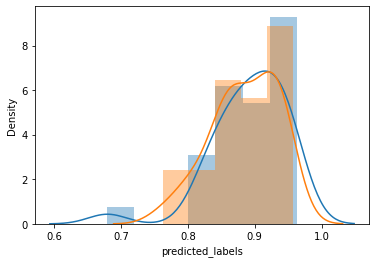

In [ ]:
train_data['predicted_labels'] = train_predictions
print(train_data[train_data['label']==1]['predicted_labels'].mean(), train_data[train_data['label']==0]['predicted_labels'].mean())

sns.distplot(train_data[train_data['label']==1]['predicted_labels'])
sns.distplot(train_data[train_data['label']==0]['predicted_labels'])

1.5516717 1.6001276


<Axes: xlabel='predicted_labels', ylabel='Density'>

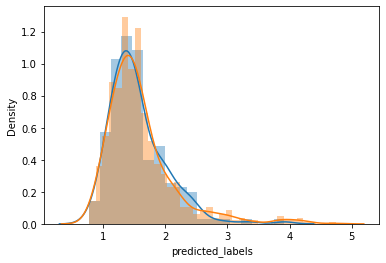

In [10]:
#kaggle euclidean_distance
df['predicted_labels'] = predictions
print(df[df['labels']==1]['predicted_labels'].mean(), df[df['labels']==0]['predicted_labels'].mean())

sns.distplot(df[df['labels']==1]['predicted_labels'])
sns.distplot(df[df['labels']==0]['predicted_labels'])

0.9998852 0.9998866


<Axes: xlabel='predicted_labels', ylabel='Density'>

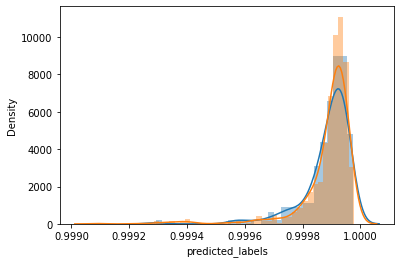

In [16]:
#kaggle cosine_similarity
df['predicted_labels'] = predictions
print(df[df['labels']==1]['predicted_labels'].mean(), df[df['labels']==0]['predicted_labels'].mean())

sns.distplot(df[df['labels']==1]['predicted_labels'])
sns.distplot(df[df['labels']==0]['predicted_labels'])

In [18]:
# Euclidean_Distance

for i in range(1,9):
    print('threshold:',i/10)
    threshold = i/10 
    predicted_labels = [1 if distance < threshold else 0 for distance in predictions]
    df['predicted_labels'] = predicted_labels
    print('Accuracy: ',sum(np.where(df['labels']==df['predicted_labels'],1,0))/1000)
    print()

threshold: 0.1
Accuracy:  0.2

threshold: 0.2
Accuracy:  0.2

threshold: 0.3
Accuracy:  0.2

threshold: 0.4
Accuracy:  0.2

threshold: 0.5
Accuracy:  0.2

threshold: 0.6
Accuracy:  0.2

threshold: 0.7
Accuracy:  0.2

threshold: 0.8
Accuracy:  0.2



In [ ]:
# Cosine_Similarity

for i in range(1,10):
    print('threshold:',i/10)
    threshold = i/10 
    predicted_labels = [1 if cos_sim > threshold else 0 for cos_sim in train_predictions]
    train_data['predicted_labels'] = predicted_labels
    print('Accuracy: ',sum(np.where(train_data['label']==train_data['predicted_labels'],1,0))/1000)
    print()

threshold: 0.1
Accuracy:  0.032

threshold: 0.2
Accuracy:  0.032

threshold: 0.3
Accuracy:  0.032

threshold: 0.4
Accuracy:  0.032

threshold: 0.5
Accuracy:  0.032

threshold: 0.6
Accuracy:  0.032

threshold: 0.7
Accuracy:  0.031

threshold: 0.8
Accuracy:  0.034

threshold: 0.9
Accuracy:  0.034



# Inferencing

In [37]:
test =  pd.read_csv('/home/team33/siamese/kaggle-llm-science-exam/test.csv')
test = pd.melt(test, id_vars=['id','prompt'], value_vars=['A', 'B', 'C', 'D', 'E'], var_name='prediction', value_name='answer_text')
test = test.reset_index(drop = True)

In [38]:
class SiameseDataset(Dataset):
    def __init__(self, prompt, answer_text):
        self.text1 = prompt
        self.text2 = answer_text

    def __len__(self):
        return len(self.text1)

    def __getitem__(self, idx):
        text1 = self.text1[idx]
        text2 = self.text2[idx]
        return text1, text2
    
dataset = SiameseDataset(test["prompt"].tolist(),test["answer_text"].tolist())
data_loader = DataLoader(dataset, batch_size=16, shuffle=False)

In [39]:
siamese_model.eval()
predictions = []

with torch.no_grad():
    for text1, text2 in data_loader:
        
        inputs1 = tokenizer(text1, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
        inputs2 = tokenizer(text2, padding="max_length", truncation=True, max_length=128, return_tensors="pt")

        inputs1 = inputs1.to(device)
        inputs2 = inputs2.to(device)

        outputs1, outputs2 = siamese_model(inputs1, inputs2)
        distances = torch.nn.functional.pairwise_distance(outputs1, outputs2)
        predictions.extend(distances.cpu().numpy())

In [40]:
test['predictions'] = predictions
test['Rank'] = test.groupby("prompt")["predictions"].rank(method="first", ascending=True)
test = test[test['Rank']<=3]

submission  = test.groupby('id')['prediction'].apply(list).reset_index()
submission['prediction'] = submission['prediction'].apply(lambda x: " ".join(x))

submission.to_csv('submission.csv', index=False)